In [153]:
## Celda 1: Importaci√≥n de librer√≠as
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan

from sklearn.model_selection import learning_curve
from scipy.stats import boxcox
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from scipy.stats import friedmanchisquare
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# Configuraci√≥n para visualizaci√≥n
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [154]:
#Cargar el dataset 
df = pd.read_csv('autos.csv')

selected_features = ['displacement', 'horsepower', 'weight', 'acceleration', 'year', 'origin']
df = df[selected_features + ['MPG']]  #MPG es la variable objetivo,son millas por gal√≥n de combustible


In [155]:
#Descripcion del dataset
#The data concerns city-cycle fuel consumption in miles per gallon, to be predicted in terms of 2 multivalued discrete and 4 continuous attributes
#El archivo esta cargado en mi github!!
#fuente https://archive.ics.uci.edu/dataset/9/auto+mpg con cantidad de features reducida.He aqu√≠ las variables que se han seleccionado para el an√°lisis:
''''
    1. mpg:           continuous   (target variable)
    
    2. displacement:  continuous
    3. horsepower:    continuous
    4. weight:        continuous
    5. acceleration:  continuous
    6. model year:    multi-valued discrete
    7. origin:        multi-valued discrete
    
'''
#Omit√≠ variables categoricas como nombre del auto, optar√© por variables num√©ricas continuas y discretas.

"'\n    1. mpg:           continuous   (target variable)\n\n    2. displacement:  continuous\n    3. horsepower:    continuous\n    4. weight:        continuous\n    5. acceleration:  continuous\n    6. model year:    multi-valued discrete\n    7. origin:        multi-valued discrete\n\n"

=== INFORMACI√ìN DEL DATASET ===
Tama√±o del dataset: (2000, 7)

=== ESTAD√çSTICAS DESCRIPTIVAS ===
       displacement   horsepower       weight  acceleration         year  \
count   2000.000000  2000.000000  2000.000000   2000.000000  2000.000000   
mean     261.975218   137.335831  3287.368680     15.805436    76.200500   
std      112.501157    53.098701   978.999572      4.597029     3.748376   
min       71.239031    46.002141  1600.104444      8.003856    70.000000   
25%      161.647892    92.144764  2439.579449     11.829282    73.000000   
50%      265.330239   136.655756  3271.136537     15.747181    76.000000   
75%      359.011350   183.759054  4115.496046     19.794138    79.000000   
max      454.891304   229.918617  4997.791022     23.991371    82.000000   

            origin          MPG  
count  2000.000000  2000.000000  
mean      1.996500    46.742194  
std       0.811059     4.939486  
min       1.000000    31.603302  
25%       1.000000    43.344253  
50%       2

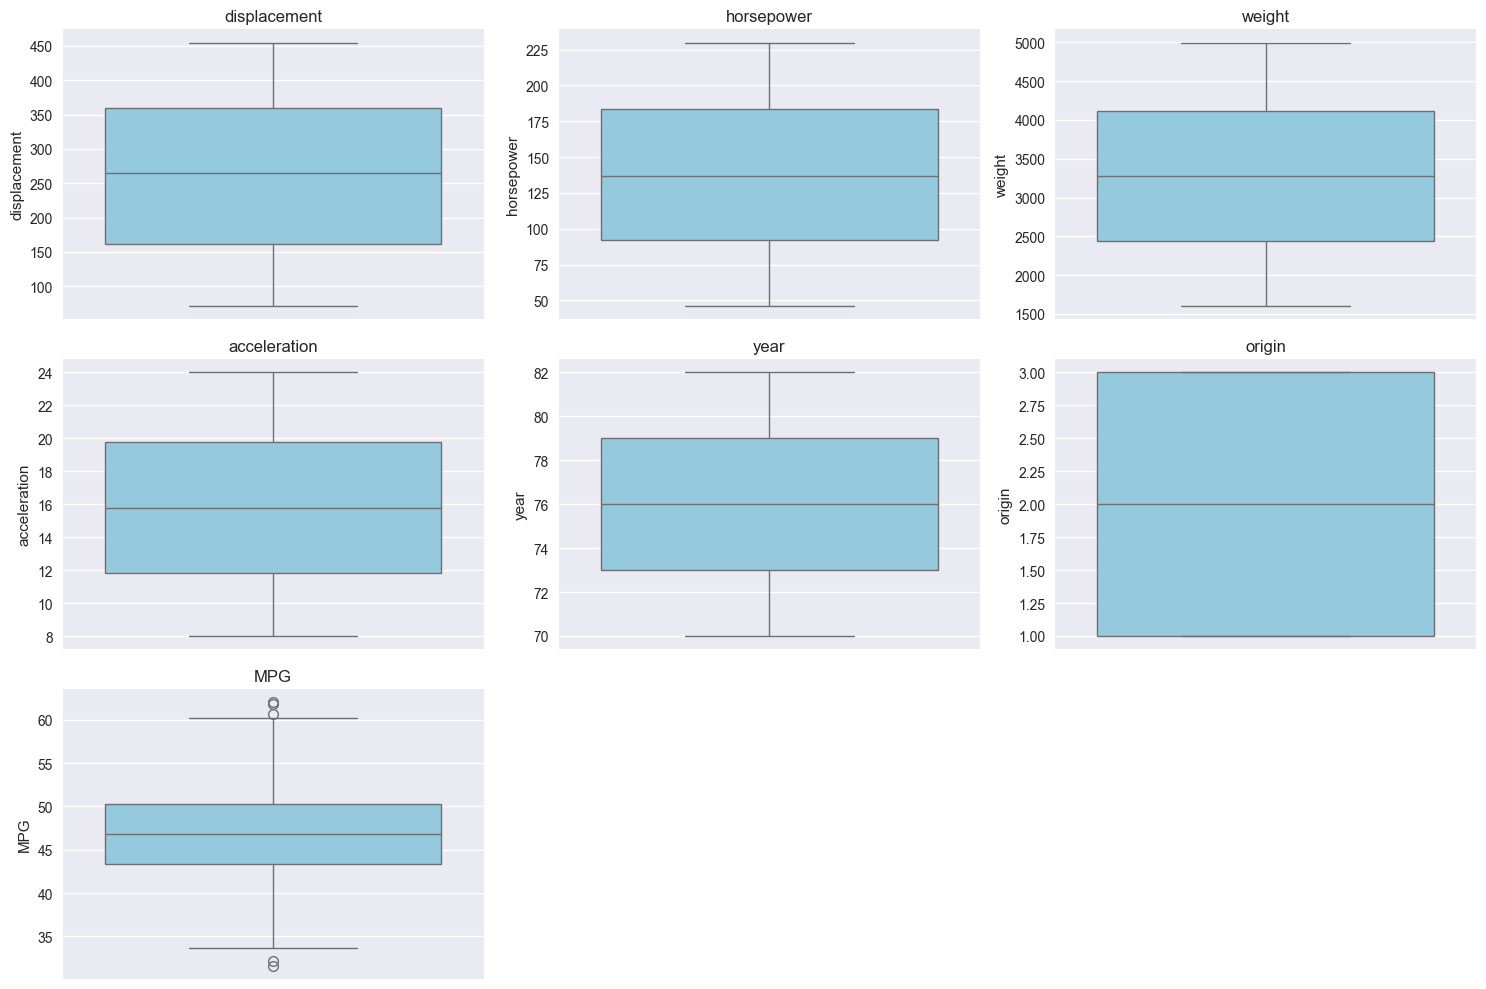

In [156]:
# Informaci√≥n del dataset
print('=== INFORMACI√ìN DEL DATASET ===')
print(f'Tama√±o del dataset: {df.shape}')

# Estad√≠sticas descriptivas
print("\n=== ESTAD√çSTICAS DESCRIPTIVAS ===")
print(df.describe())

# Informaci√≥n general del dataset
print("\n=== INFO GENERAL ===")
print(df.info())

# Revisi√≥n de valores faltantes
print("=== VALORES FALTANTES ===")
print(df.isnull().sum())


# Boxplots para detectar outliers visualmente

plt.figure(figsize=(15, 10))
for i, column in enumerate(df.columns, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(data=df, y=column, color="skyblue")
    plt.title(column)
plt.tight_layout()
plt.show()


In [157]:
#Notemos que no hay missing values.
#Ahora que hemos visualizado los datos:
#Vamos a detectar outliers usando el m√©todo IQR (Rango Intercuart√≠lico)
#Se lo aplico a la variable objetivo 'MPG' pues es la unica que evidencia outliers en el boxplot
#Utilizo el m√©todo IQR para detectar outliers

Q1 = df['MPG'].quantile(0.25)
Q3 = df['MPG'].quantile(0.75)
IQR = Q3 - Q1
outliers_iqr = ((df['MPG'] < (Q1 - 1.5 * IQR)) |
                (df['MPG'] > (Q3 + 1.5 * IQR)))
print(f"Number of outliers detected by IQR method: {np.sum(outliers_iqr)}")



Number of outliers detected by IQR method: 5


In [158]:
#La cantidad de outliers detectados por el m√©todo IQR es 5,vamos a transformar la variable objetivo 'MPG' usando la transformaci√≥n Box-Cox
#He decidido no eliminarlos porque no son muchos y la variable objetivo es importante para el modelo.
#Ademas, no parecen ser outliers extremos, por lo que la transformaci√≥n Box-Cox puede ayudar a normalizar la distribuci√≥n sin eliminarlos.
#Esta columna,tal como se evidencia en el boxplot,no tiene valores negativos, por lo que la transformaci√≥n Box-Cox es adecuada.

mpg = df["MPG"]
df["MPG_boxcox"], fitted_lambda = boxcox(mpg)
print("Lambda:", fitted_lambda)



Lambda: 1.1013813311942027


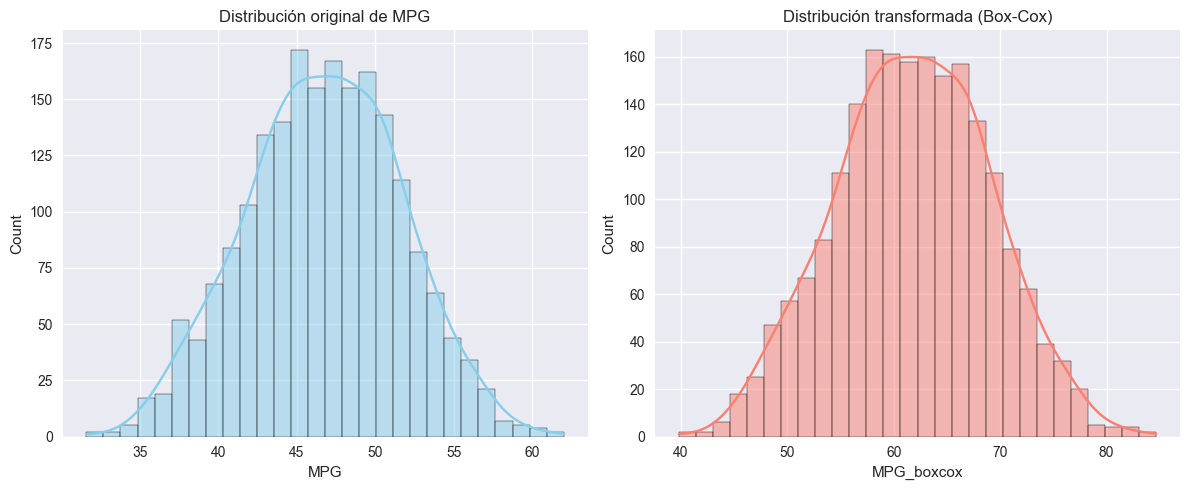

In [159]:
# Se realiz√≥ la transformaci√≥n Box-Cox sobre la variable 'MPG' para mejorar su normalidad.
# El valor de lambda estimado fue 1.10, lo cual est√° muy cerca de 1 (la identidad),
# indicando que la distribuci√≥n original no requer√≠a una transformaci√≥n significativa.
# Por este motivo, se opta por continuar con los datos originales sin aplicar la transformaci√≥n.

# Visualizaci√≥n de la distribuci√≥n original y transformada


plt.figure(figsize=(12, 5))

# Original
plt.subplot(1, 2, 1)
sns.histplot(df["MPG"], kde=True, color='skyblue')
plt.title("Distribuci√≥n original de MPG")

# Box-Cox
plt.subplot(1, 2, 2)
sns.histplot(df["MPG_boxcox"], kde=True, color='salmon')
plt.title("Distribuci√≥n transformada (Box-Cox)")

plt.tight_layout()
plt.show()


In [160]:
# Se elimina la columna 'MPG_boxcox' ya que se decidi√≥ continuar con los datos originales,
# debido a que la transformaci√≥n no fue necesaria (lambda ‚âà 1).
df.drop(columns=["MPG_boxcox"], inplace=True)


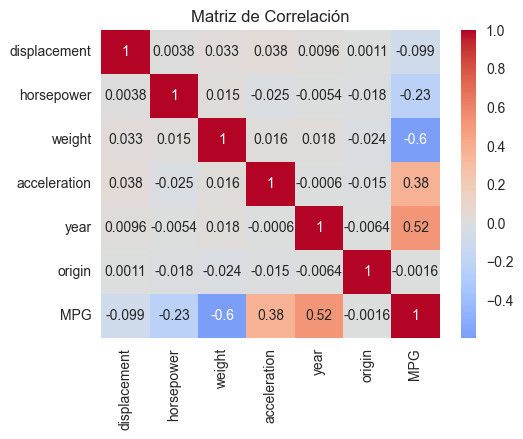

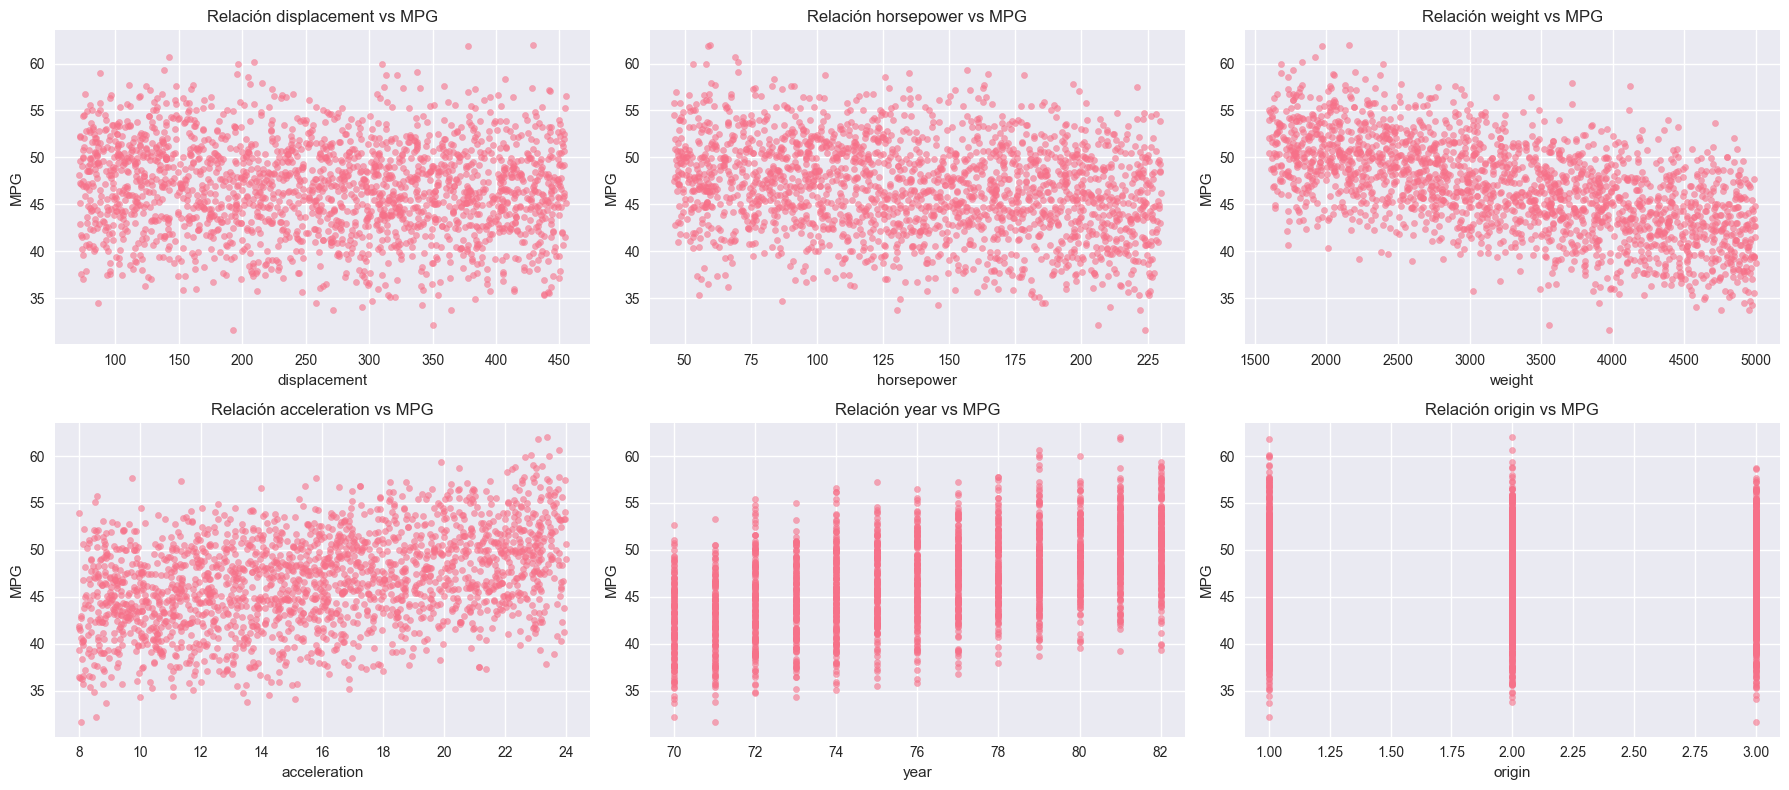

In [161]:
# Visualizaci√≥n de correlaciones


plt.figure(figsize=(12, 4))

# Matriz de correlaci√≥n
plt.subplot(1, 2, 1)
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Matriz de Correlaci√≥n')

#Dispersi√≥n de todas las features contra el target
cols = 3
rows = (len(selected_features) + cols - 1) // cols  # en este caso, 2 filas

plt.figure(figsize=(cols * 6, rows * 4))

for i, feature in enumerate(selected_features, 1):
    plt.subplot(rows, cols, i)
    plt.scatter(df[feature], df['MPG'], alpha=0.6, s=20)
    plt.xlabel(feature)
    plt.ylabel('MPG')
    plt.title(f'Relaci√≥n {feature} vs MPG')

plt.tight_layout()
plt.show()



In [162]:
# Celda 3: Preparaci√≥n de datos para modelado

# Separar caracter√≠sticas y variable objetivo
X = df.drop('MPG', axis=1)
y = df['MPG']

# Divisi√≥n en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Estandarizaci√≥n (importante para redes neuronales)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("=== PREPARACI√ìN DE DATOS ===")
print(f"Tama√±o entrenamiento: {X_train.shape}")
print(f"Tama√±o prueba: {X_test.shape}")
print(f"Rango de y_train: [{y_train.min():.2f}, {y_train.max():.2f}]")


=== PREPARACI√ìN DE DATOS ===
Tama√±o entrenamiento: (1600, 6)
Tama√±o prueba: (400, 6)
Rango de y_train: [31.60, 62.01]


In [163]:
#Diagnostico de supuestos para regresion

X = df[selected_features]
y = df['MPG']

# Agregar constante (intercepto)
X = sm.add_constant(X)

# Ajustar el modelo OLS
model = sm.OLS(y, X).fit()

#Heterocedasticidad
bp_stat, bp_p, _, _ = het_breuschpagan(model.resid, X)
print(f"Breusch-Pagan p-valor: {bp_p:.4f} - {'HETEROCEDASTICIDAD' if bp_p < 0.05 else 'HOMOCEDASTICIDAD'}")

# Multicolinealidad

vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(f"\nFactor de Inflaci√≥n de Varianza:")
print(vif_data)


# Normalidad
_, shapiro_p_real = stats.shapiro(model.resid)
print(f"\nShapiro-Wilk p-valor: {shapiro_p_real:.4f} - {'NO NORMAL' if shapiro_p_real < 0.05 else 'NORMAL'}")

Breusch-Pagan p-valor: 0.2519 - HOMOCEDASTICIDAD

Factor de Inflaci√≥n de Varianza:
        feature         VIF
0         const  453.743499
1  displacement    1.002575
2    horsepower    1.001247
3        weight    1.002377
4  acceleration    1.002565
5          year    1.000472
6        origin    1.001129

Shapiro-Wilk p-valor: 0.7608 - NORMAL


In [164]:
print('''Se evaluaron los supuestos cl√°sicos del modelo para asegurar la validez de los resultados:

#La prueba de Breusch-Pagan para homocedasticidad arroj√≥ un p-valor de 0.2519, lo que indica que no hay evidencia suficiente para rechazar la hip√≥tesis de varianza constante de los errores. Por lo tanto, se cumple el supuesto de homocedasticidad.

#El an√°lisis del Factor de Inflaci√≥n de Varianza (VIF) muestra valores muy bajos para todas las variables independientes (todos alrededor de 1), lo que sugiere que no existe multicolinealidad problem√°tica entre las variables predictoras.

#La prueba de Shapiro-Wilk aplicada a los residuos report√≥ un p-valor de 0.7608, indicando que no se rechaza la normalidad de los residuos. Esto permite asumir que los errores siguen una distribuci√≥n normal, cumpliendo con ese supuesto.

Dado que los supuestos principales se cumplen, se considera apropiado continuar con el modelado y an√°lisis inferencial utilizando regresi√≥n lineal m√∫ltiple.''')

Se evaluaron los supuestos cl√°sicos del modelo para asegurar la validez de los resultados:

#La prueba de Breusch-Pagan para homocedasticidad arroj√≥ un p-valor de 0.2519, lo que indica que no hay evidencia suficiente para rechazar la hip√≥tesis de varianza constante de los errores. Por lo tanto, se cumple el supuesto de homocedasticidad.

#El an√°lisis del Factor de Inflaci√≥n de Varianza (VIF) muestra valores muy bajos para todas las variables independientes (todos alrededor de 1), lo que sugiere que no existe multicolinealidad problem√°tica entre las variables predictoras.

#La prueba de Shapiro-Wilk aplicada a los residuos report√≥ un p-valor de 0.7608, indicando que no se rechaza la normalidad de los residuos. Esto permite asumir que los errores siguen una distribuci√≥n normal, cumpliendo con ese supuesto.

Dado que los supuestos principales se cumplen, se considera apropiado continuar con el modelado y an√°lisis inferencial utilizando regresi√≥n lineal m√∫ltiple.


In [165]:
# Celda 4: Implementaci√≥n de Regresi√≥n Lineal M√∫ltiple
print('=== REGRESI√ìN LINEAL M√öLTIPLE ===')

# Entrenar modelo
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predicciones
y_pred_lr_train = lr_model.predict(X_train)
y_pred_lr_test = lr_model.predict(X_test)

# M√©tricas
lr_train_mse = mean_squared_error(y_train, y_pred_lr_train)
lr_test_mse = mean_squared_error(y_test, y_pred_lr_test)
lr_train_r2 = r2_score(y_train, y_pred_lr_train)
lr_test_r2 = r2_score(y_test, y_pred_lr_test)

print(f'MSE Entrenamiento: {lr_train_mse:.4f}')
print(f'MSE Prueba: {lr_test_mse:.4f}')
print(f'R¬≤ Entrenamiento: {lr_train_r2:.4f}')
print(f'R¬≤ Prueba: {lr_test_r2:.4f}')

# Coeficientes
print(f'\nCoeficientes del modelo:')
feature_names = selected_features
for coef, name in zip(lr_model.coef_, feature_names):
    print(f'  {name}: {coef:.4f}')
print(f'  Intercepto: {lr_model.intercept_:.4f}')


#Analizo significancia de los coeficientes
X = sm.add_constant(df[selected_features])
y = df['MPG']

modelo = sm.OLS(y, X).fit()
print(modelo.summary())


=== REGRESI√ìN LINEAL M√öLTIPLE ===
MSE Entrenamiento: 3.9270
MSE Prueba: 4.3027
R¬≤ Entrenamiento: 0.8388
R¬≤ Prueba: 0.8244

Coeficientes del modelo:
  displacement: -0.0045
  horsepower: -0.0200
  weight: -0.0030
  acceleration: 0.4166
  year: 0.6971
  origin: -0.0786
  Intercepto: 1.1607
                            OLS Regression Results                            
Dep. Variable:                    MPG   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                     1693.
Date:                Fri, 18 Jul 2025   Prob (F-statistic):               0.00
Time:                        01:40:03   Log-Likelihood:                -4224.2
No. Observations:                2000   AIC:                             8462.
Df Residuals:                    1993   BIC:                             8502.
Df Model:                           6                                      

In [166]:
print("ANALISIS DE SIGNIFICANCIA DE LOS COEFICIENTES")
print('''
Las variables displacement, horsepower, weight, acceleration y year presentan p-valores inferiores a 0.05, 
lo que indica que sus coeficientes son estad√≠sticamente significativos al nivel del 5%. 
Esto sugiere que estas variables tienen una relaci√≥n significativa con la variable objetivo (MPG).
      
Por el contrario, la variable origin presenta un p-valor de 0.255, lo cual indica que no es estad√≠sticamente significativa en el modelo, es decir, 
no se puede afirmar con evidencia suficiente que tenga un efecto distinto de cero sobre MPG en presencia de las dem√°s variables.''')

print("-" * 80)
print("ANALISIS DE RESULTADOS OBTENIDOS")
print('''
Los resultados indican un buen ajuste del modelo, con un error cuadr√°tico medio (MSE) de 3.9270 en el conjunto de entrenamiento y 4.3027 en el conjunto de prueba. 
Esto sugiere que el modelo predice con precisi√≥n razonable tanto los datos usados para entrenar como los datos nuevos.
      
El coeficiente de determinaci√≥n ùëÖ^2 es 0.8388 en entrenamiento y 0.8244 en prueba, lo que significa que aproximadamente el 83-84% de la variabilidad en MPG 
se explica por las variables independientes incluidas en el modelo. Esto denota una capacidad explicativa alta.
      
displacement, horsepower y weight tienen coeficientes negativos , indicando que a medida que estas variables aumentan, el consumo de combustible (MPG) tiende a disminuir,manteniendo constantes las dem√°s variables.
Por otro lado, acceleration y year tienen coeficientes positivos, lo que sugiere que un aumento en estas variables est√° asociado con un mayor consumo de combustible (MPG), manteniendo constantes las dem√°s variables.
origin tiene un coeficiente negativo (-0.0630), pero no resulta estad√≠sticamente significativo (p=0.255), lo que indica que no se puede afirmar con evidencia suficiente que tenga un efecto distinto de cero sobre MPG en presencia de las dem√°s variables.

Finalmente, el estad√≠stico Durbin-Watson (2.036) sugiere que no existe autocorrelaci√≥n significativa en los residuos, y las pruebas de normalidad (Omnibus y Jarque-Bera) no rechazan la normalidad de los residuos.
      
''')

ANALISIS DE SIGNIFICANCIA DE LOS COEFICIENTES

Las variables displacement, horsepower, weight, acceleration y year presentan p-valores inferiores a 0.05, 
lo que indica que sus coeficientes son estad√≠sticamente significativos al nivel del 5%. 
Esto sugiere que estas variables tienen una relaci√≥n significativa con la variable objetivo (MPG).

Por el contrario, la variable origin presenta un p-valor de 0.255, lo cual indica que no es estad√≠sticamente significativa en el modelo, es decir, 
no se puede afirmar con evidencia suficiente que tenga un efecto distinto de cero sobre MPG en presencia de las dem√°s variables.
--------------------------------------------------------------------------------
ANALISIS DE RESULTADOS OBTENIDOS

Los resultados indican un buen ajuste del modelo, con un error cuadr√°tico medio (MSE) de 3.9270 en el conjunto de entrenamiento y 4.3027 en el conjunto de prueba. 
Esto sugiere que el modelo predice con precisi√≥n razonable tanto los datos usados para entrena

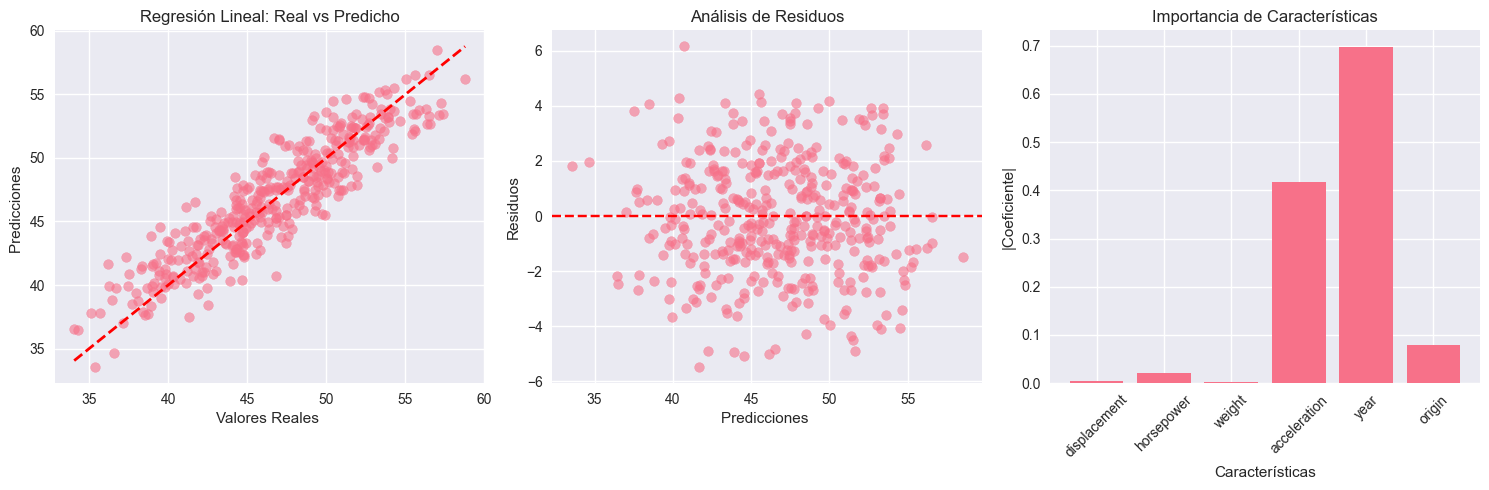

In [167]:
# Celda 5: An√°lisis de Regresi√≥n Lineal

# Visualizaci√≥n de resultados
plt.figure(figsize=(15, 5))

# Gr√°fico 1: Valores reales vs predichos
plt.subplot(1, 3, 1)
plt.scatter(y_test, y_pred_lr_test, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Valores Reales ')
plt.ylabel('Predicciones ')
plt.title('Regresi√≥n Lineal: Real vs Predicho')

# Gr√°fico 2: Residuos
plt.subplot(1, 3, 2)
residuals_lr = y_test - y_pred_lr_test
plt.scatter(y_pred_lr_test, residuals_lr, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicciones ')
plt.ylabel('Residuos')
plt.title('An√°lisis de Residuos')

# Gr√°fico 3: Importancia de caracter√≠sticas (coeficientes)
plt.subplot(1, 3, 3)
feature_names = selected_features
feature_importance = abs(lr_model.coef_)
plt.bar(feature_names, feature_importance)
plt.xlabel('Caracter√≠sticas')
plt.ylabel('|Coeficiente|')
plt.title('Importancia de Caracter√≠sticas')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


In [168]:
# Celda 6: Implementaci√≥n de √Årbol de Regresi√≥n
# Entrenar modelo con diferentes profundidades para encontrar la √≥ptima
depths = [3, 5, 7, 10, 15, 20]
best_depth = 0
best_score = float('-inf')

for depth in depths:
    tree_temp = DecisionTreeRegressor(max_depth=depth, random_state=42)
    scores = cross_val_score(tree_temp, X_train, y_train, cv=5, scoring='r2')
    avg_score = scores.mean()
    if avg_score > best_score:
        best_score = avg_score
        best_depth = depth

print(f"Mejor profundidad encontrada: {best_depth}")        
# Entrenar modelo final
tree_model = DecisionTreeRegressor(max_depth=best_depth, random_state=42)
tree_model.fit(X_train, y_train)

# Predicciones
y_pred_tree_train = tree_model.predict(X_train)
y_pred_tree_test = tree_model.predict(X_test)

# M√©tricas
tree_train_mse = mean_squared_error(y_train, y_pred_tree_train)
tree_test_mse = mean_squared_error(y_test, y_pred_tree_test)
tree_train_r2 = r2_score(y_train, y_pred_tree_train)
tree_test_r2 = r2_score(y_test, y_pred_tree_test)

print(f"MSE Entrenamiento: {tree_train_mse:.4f}")
print(f"MSE Prueba: {tree_test_mse:.4f}")
print(f"R¬≤ Entrenamiento: {tree_train_r2:.4f}")
print(f"R¬≤ Prueba: {tree_test_r2:.4f}")

Mejor profundidad encontrada: 7
MSE Entrenamiento: 3.2804
MSE Prueba: 8.5879
R¬≤ Entrenamiento: 0.8653
R¬≤ Prueba: 0.6496


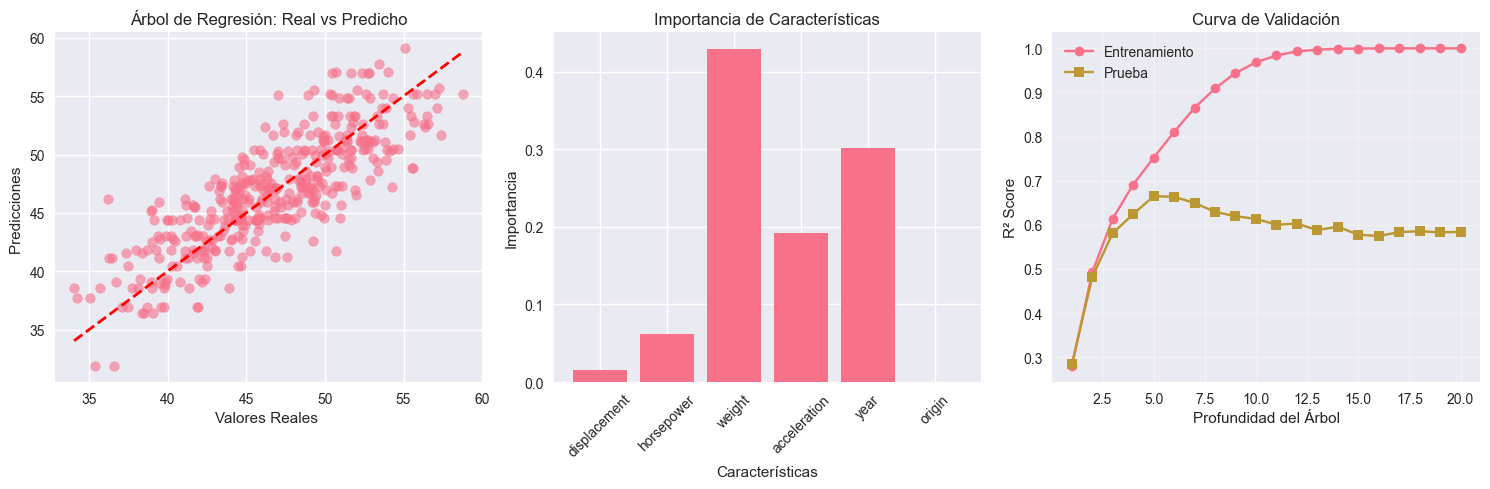

displacement: 0.0151
horsepower: 0.0620
weight: 0.4291
acceleration: 0.1920
year: 0.3016
origin: 0.0002


In [169]:
# Celda 7: An√°lisis de √Årbol de Regresi√≥n
# Visualizaci√≥n de resultados
plt.figure(figsize=(15, 5))

# Gr√°fico 1: Valores reales vs predichos
plt.subplot(1, 3, 1)
plt.scatter(y_test, y_pred_tree_test, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Valores Reales ')
plt.ylabel('Predicciones ')
plt.title('√Årbol de Regresi√≥n: Real vs Predicho')

# Gr√°fico 2: Importancia de caracter√≠sticas
plt.subplot(1, 3, 2)
feature_names = selected_features
feature_importance = tree_model.feature_importances_
plt.bar(feature_names, feature_importance)
plt.xlabel('Caracter√≠sticas')
plt.ylabel('Importancia')
plt.title('Importancia de Caracter√≠sticas')
plt.xticks(rotation=45)

# Gr√°fico 3: An√°lisis de profundidad
plt.subplot(1, 3, 3)
depths_analysis = range(1, 21)
train_scores = []
test_scores = []

for depth in depths_analysis:
    tree_temp = DecisionTreeRegressor(max_depth=depth, random_state=42)
    tree_temp.fit(X_train, y_train)
    train_scores.append(r2_score(y_train, tree_temp.predict(X_train)))
    test_scores.append(r2_score(y_test, tree_temp.predict(X_test)))

plt.plot(depths_analysis, train_scores, label='Entrenamiento', marker='o')
plt.plot(depths_analysis, test_scores, label='Prueba', marker='s')
plt.xlabel('Profundidad del √Årbol')
plt.ylabel('R¬≤ Score')
plt.title('Curva de Validaci√≥n')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

for name, importance in zip(feature_names, feature_importance):
    print(f"{name}: {importance:.4f}")


In [170]:
print("ANALISIS DE IMPORTANCIA DE CARACTERISTICAS")
print("")

print("En nuestro grafico de importancia de caracter√≠sticas, podemos observar que:")
print('''
#La variable m√°s influyente fue weight, con una importancia de aproximadamente 0.43. Esto indica que el peso del veh√≠culo es el factor que m√°s contribuye a explicar el consumo de combustible en el modelo, lo cual es coherente ya que veh√≠culos m√°s pesados tienden a consumir m√°s combustible.

#La segunda variable en importancia fue year (0.30), lo que sugiere que el a√±o de fabricaci√≥n tiene un impacto considerable en la eficiencia del veh√≠culo.

#En tercer lugar aparece acceleration (0.19), lo cual indica que la capacidad de aceleraci√≥n del veh√≠culo tambi√©n tiene un peso relevante en la predicci√≥n del consumo.

#horsepower (0.06) y displacement (0.015) tienen menor peso en el modelo. Finalmente, origin (0.0002) result√≥ pr√°cticamente irrelevante, lo que indica que el pa√≠s o regi√≥n de fabricaci√≥n no tiene impacto significativo en la predicci√≥n de MPG en este conjunto de datos.

En resumen, el modelo identifica al peso, al a√±o de fabricaci√≥n y a la aceleraci√≥n como los factores m√°s determinantes para predecir el consumo de combustible. ''')

ANALISIS DE IMPORTANCIA DE CARACTERISTICAS

En nuestro grafico de importancia de caracter√≠sticas, podemos observar que:

#La variable m√°s influyente fue weight, con una importancia de aproximadamente 0.43. Esto indica que el peso del veh√≠culo es el factor que m√°s contribuye a explicar el consumo de combustible en el modelo, lo cual es coherente ya que veh√≠culos m√°s pesados tienden a consumir m√°s combustible.

#La segunda variable en importancia fue year (0.30), lo que sugiere que el a√±o de fabricaci√≥n tiene un impacto considerable en la eficiencia del veh√≠culo.

#En tercer lugar aparece acceleration (0.19), lo cual indica que la capacidad de aceleraci√≥n del veh√≠culo tambi√©n tiene un peso relevante en la predicci√≥n del consumo.

#horsepower (0.06) y displacement (0.015) tienen menor peso en el modelo. Finalmente, origin (0.0002) result√≥ pr√°cticamente irrelevante, lo que indica que el pa√≠s o regi√≥n de fabricaci√≥n no tiene impacto significativo en la predicci√≥n de MPG 

In [171]:
print('Estudio de underfitting y overfitting')
print('')
print('''
En el an√°lisis del modelo de √°rbol de regresi√≥n, se observa una diferencia significativa entre el desempe√±o en el conjunto de entrenamiento y en el conjunto de prueba. 
Con una profundidad √≥ptima encontrada de 7, el modelo alcanza un ùëÖ^2 de 0.8653 en entrenamiento, pero cae a 0.6496 en prueba.Este comportamiento indica la presencia de overfitting.
La diferencia entre el rendimiento en entrenamiento y prueba sugiere que el modelo ha aprendido patrones espec√≠ficos del conjunto de entrenamiento, pero no generaliza bien a datos nuevos.
      
      ''')

print('''Para controlar el sobreajuste, aplico poda previa, limitando la profundidad y el tama√±o m√≠nimo de los nodos durante la construcci√≥n del √°rbol. 
Adem√°s,uso validaci√≥n cruzada para elegir los mejores hiperpar√°metros y asegurar buena generalizaci√≥n. ''')

Estudio de underfitting y overfitting


En el an√°lisis del modelo de √°rbol de regresi√≥n, se observa una diferencia significativa entre el desempe√±o en el conjunto de entrenamiento y en el conjunto de prueba. 
Con una profundidad √≥ptima encontrada de 7, el modelo alcanza un ùëÖ^2 de 0.8653 en entrenamiento, pero cae a 0.6496 en prueba.Este comportamiento indica la presencia de overfitting.
La diferencia entre el rendimiento en entrenamiento y prueba sugiere que el modelo ha aprendido patrones espec√≠ficos del conjunto de entrenamiento, pero no generaliza bien a datos nuevos.

      
Para controlar el sobreajuste, aplico poda previa, limitando la profundidad y el tama√±o m√≠nimo de los nodos durante la construcci√≥n del √°rbol. 
Adem√°s,uso validaci√≥n cruzada para elegir los mejores hiperpar√°metros y asegurar buena generalizaci√≥n. 


In [172]:
#Aplico poda previa al √°rbol de regresi√≥n para controlar el sobreajuste
print('=== PODA PREVIA DEL √ÅRBOL DE REGRESI√ìN ===')
# Definir rangos para hiperpar√°metros de poda previa
param_grid = {
    'max_depth': [3, 5, 7],              # Profundidad m√°xima menor para evitar complejidad alta
    'min_samples_split': [10, 20],       # N√∫mero m√≠nimo de muestras para dividir un nodo
    'min_samples_leaf': [5, 10]          # N√∫mero m√≠nimo de muestras en una hoja
}

best_score = float('-inf')
best_params = {}

# B√∫squeda manual con validaci√≥n cruzada
for depth in param_grid['max_depth']:
    for min_split in param_grid['min_samples_split']:
        for min_leaf in param_grid['min_samples_leaf']:
            tree = DecisionTreeRegressor(max_depth=depth,
                                         min_samples_split=min_split,
                                         min_samples_leaf=min_leaf,
                                         random_state=42)
            scores = cross_val_score(tree, X_train, y_train, cv=5, scoring='r2')
            avg_score = scores.mean()
            if avg_score > best_score:
                best_score = avg_score
                best_params = {
                    'max_depth': depth,
                    'min_samples_split': min_split,
                    'min_samples_leaf': min_leaf
                }

print("Mejores hiperpar√°metros encontrados para controlar overfitting:")
print(best_params)
print(f"Mejor R¬≤ promedio en validaci√≥n cruzada: {best_score:.4f}")

# Entrenar modelo final con los mejores hiperpar√°metros
tree_model_poda = DecisionTreeRegressor(**best_params, random_state=42)
tree_model_poda.fit(X_train, y_train)

# Evaluar en test
y_pred_train_poda = tree_model_poda.predict(X_train)
y_pred_test_poda = tree_model_poda.predict(X_test)



print(f"MSE Entrenamiento (podado): {mean_squared_error(y_train, y_pred_train_poda):.4f}")
print(f"MSE Prueba (podado): {mean_squared_error(y_test, y_pred_test_poda):.4f}")
print(f"R¬≤ Entrenamiento (podado): {r2_score(y_train, y_pred_train_poda):.4f}")
print(f"R¬≤ Prueba (podado): {r2_score(y_test, y_pred_test_poda):.4f}")


=== PODA PREVIA DEL √ÅRBOL DE REGRESI√ìN ===
Mejores hiperpar√°metros encontrados para controlar overfitting:
{'max_depth': 7, 'min_samples_split': 10, 'min_samples_leaf': 10}
Mejor R¬≤ promedio en validaci√≥n cruzada: 0.7007
MSE Entrenamiento (podado): 3.9592
MSE Prueba (podado): 7.5627
R¬≤ Entrenamiento (podado): 0.8374
R¬≤ Prueba (podado): 0.6914


In [173]:
print('''
Con esta configuraci√≥n, el desempe√±o del modelo mejor√≥ su capacidad de generalizaci√≥n, reflejado en un aumento del R^2 en prueba a 0.6914, mientras que el R^2 en entrenamiento disminuy√≥ ligeramente a 0.8374, indicando un mejor balance entre ajuste y generalizaci√≥n.
Asimismo, el error cuadr√°tico medio (MSE) en prueba baj√≥ de 8.5879 a 7.5627, reforzando la mejora en la predicci√≥n sobre datos no vistos.

Aunque el sobreajuste no se elimin√≥ completamente, la reducci√≥n observada evidencia que el pre-poda es una t√©cnica efectiva para controlar la complejidad del √°rbol y mejorar su desempe√±o en datos nuevos.''')


Con esta configuraci√≥n, el desempe√±o del modelo mejor√≥ su capacidad de generalizaci√≥n, reflejado en un aumento del R^2 en prueba a 0.6914, mientras que el R^2 en entrenamiento disminuy√≥ ligeramente a 0.8374, indicando un mejor balance entre ajuste y generalizaci√≥n.
Asimismo, el error cuadr√°tico medio (MSE) en prueba baj√≥ de 8.5879 a 7.5627, reforzando la mejora en la predicci√≥n sobre datos no vistos.

Aunque el sobreajuste no se elimin√≥ completamente, la reducci√≥n observada evidencia que el pre-poda es una t√©cnica efectiva para controlar la complejidad del √°rbol y mejorar su desempe√±o en datos nuevos.


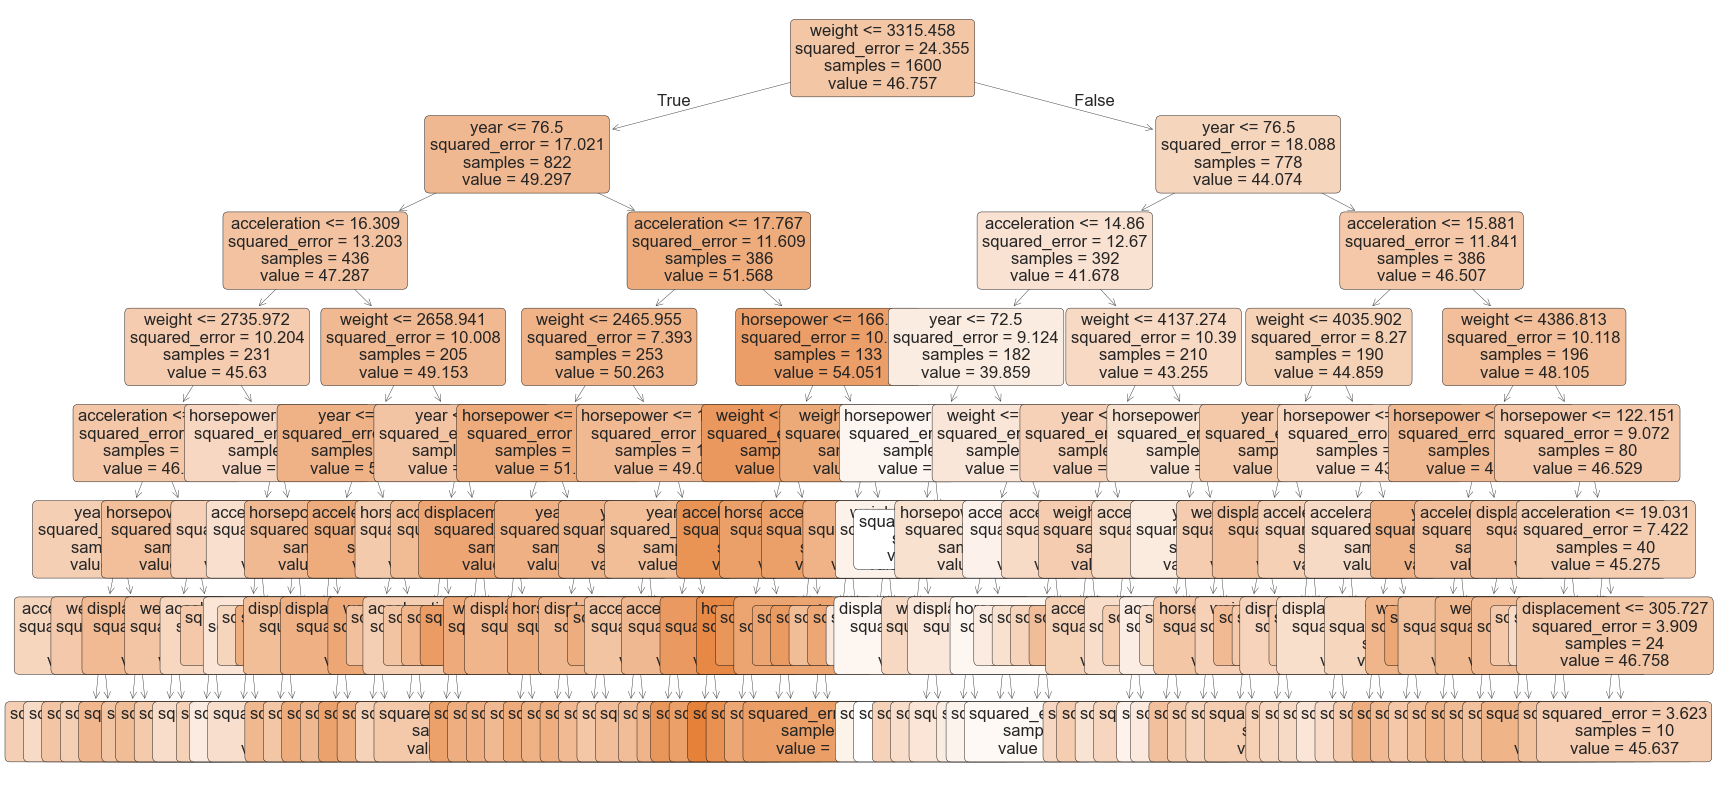

In [174]:
#Visualizacion del √°rbol 
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plot_tree(tree_model_poda, feature_names=selected_features, filled=True, rounded=True, fontsize=12)
plt.show()


In [175]:
## Celda 8: Implementaci√≥n de Red Neuronal
print("=== RED NEURONAL (MLP) ===")


# Probar diferentes arquitecturas
architectures = [
    (50,), (100,), (50, 25), (100, 50), (100, 50, 25)
]

best_architecture = None
best_score = float('-inf')


for arch in architectures:
    mlp_temp = MLPRegressor(
        hidden_layer_sizes=arch,
        max_iter=1000,
        random_state=42,
        early_stopping=True,
        validation_fraction=0.1
    )
    scores = cross_val_score(mlp_temp, X_train_scaled, y_train, cv=3, scoring='r2')
    avg_score = scores.mean()
    if avg_score > best_score:
        best_score = avg_score
        best_architecture = arch


print(f"Mejor arquitectura encontrada: {best_architecture}")

# Entrenar modelo final
mlp_model = MLPRegressor(
    hidden_layer_sizes=best_architecture,
    max_iter=1000,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.1
)

mlp_model.fit(X_train_scaled, y_train)

# Predicciones
y_pred_mlp_train = mlp_model.predict(X_train_scaled)
y_pred_mlp_test = mlp_model.predict(X_test_scaled)

# M√©tricas
mlp_train_mse = mean_squared_error(y_train, y_pred_mlp_train)
mlp_test_mse = mean_squared_error(y_test, y_pred_mlp_test)
mlp_train_r2 = r2_score(y_train, y_pred_mlp_train)
mlp_test_r2 = r2_score(y_test, y_pred_mlp_test)

print(f"MSE Entrenamiento: {mlp_train_mse:.4f}")
print(f"MSE Prueba: {mlp_test_mse:.4f}")
print(f"R¬≤ Entrenamiento: {mlp_train_r2:.4f}")
print(f"R¬≤ Prueba: {mlp_test_r2:.4f}")
print(f"N√∫mero de iteraciones: {mlp_model.n_iter_}")



=== RED NEURONAL (MLP) ===
Mejor arquitectura encontrada: (50, 25)
MSE Entrenamiento: 3.8174
MSE Prueba: 4.8723
R¬≤ Entrenamiento: 0.8433
R¬≤ Prueba: 0.8012
N√∫mero de iteraciones: 338


In [176]:
print('''
Se entren√≥ una red neuronal con diferentes arquitecturas y se seleccion√≥ autom√°ticamente la mejor, que result√≥ ser (50, 25).
Los resultados muestran un buen ajuste del modelo:
El R¬≤ en entrenamiento fue 0.84 y en prueba 0.80, lo que indica buena capacidad de generalizaci√≥n.
La diferencia entre ambos R¬≤ no sugiere un sobreajuste severo.
El modelo convergi√≥ en 338 iteraciones, gracias al uso de early stopping, evitando un entrenamiento innecesario o inestable.''')


Se entren√≥ una red neuronal con diferentes arquitecturas y se seleccion√≥ autom√°ticamente la mejor, que result√≥ ser (50, 25).
Los resultados muestran un buen ajuste del modelo:
El R¬≤ en entrenamiento fue 0.84 y en prueba 0.80, lo que indica buena capacidad de generalizaci√≥n.
La diferencia entre ambos R¬≤ no sugiere un sobreajuste severo.
El modelo convergi√≥ en 338 iteraciones, gracias al uso de early stopping, evitando un entrenamiento innecesario o inestable.


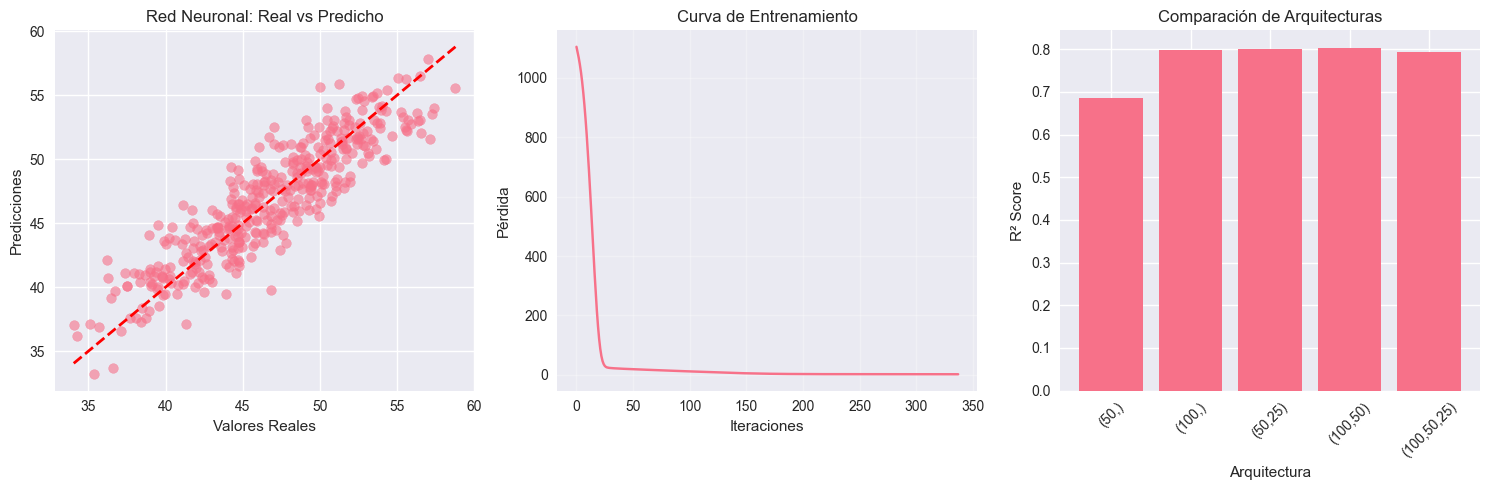

In [177]:
## Celda 9: An√°lisis de Red Neuronal
# Visualizaci√≥n de resultados
plt.figure(figsize=(15, 5))

# Gr√°fico 1: Valores reales vs predichos
plt.subplot(1, 3, 1)
plt.scatter(y_test, y_pred_mlp_test, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Red Neuronal: Real vs Predicho')

# Gr√°fico 2: Curva de p√©rdida
plt.subplot(1, 3, 2)
plt.plot(mlp_model.loss_curve_)
plt.xlabel('Iteraciones')
plt.ylabel('P√©rdida')
plt.title('Curva de Entrenamiento')
plt.grid(True, alpha=0.3)


# Gr√°fico 3: Comparaci√≥n de arquitecturas
plt.subplot(1, 3, 3)
arch_names = ['(50,)', '(100,)', '(50,25)', '(100,50)', '(100,50,25)']
arch_scores = []
for arch in architectures:
    mlp_temp = MLPRegressor(
        hidden_layer_sizes=arch,
        max_iter=500,
        random_state=42
    )
    mlp_temp.fit(X_train_scaled, y_train)
    score = r2_score(y_test, mlp_temp.predict(X_test_scaled))
    arch_scores.append(score)

plt.bar(arch_names, arch_scores)
plt.xlabel('Arquitectura')
plt.ylabel('R¬≤ Score')
plt.title('Comparaci√≥n de Arquitecturas')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()




In [178]:
print("Analisis de la curva de entrenamiento")
print('''
La curva de p√©rdida durante el entrenamiento muestra un descenso claro y constante desde un valor inicial alto (alrededor de 1100) hasta un valor mucho m√°s bajo (aproximadamente 1.89). 
Esto indica que el modelo ha logrado minimizar exitosamente la funci√≥n de p√©rdida a medida que avanzan las iteraciones.
No se observan oscilaciones grandes ni estancamientos bruscos, lo que sugiere un proceso de aprendizaje estable y progresivo.
El hecho de que la p√©rdida final sea baja y que la curva se estabilice es una buena se√±al de que el modelo logr√≥ converger correctamente, evitando problemas de sobreajuste evidentes en esta etapa.''')
print("-" * 80)
print("Estrategias para prevenir el overfitting")
print('''
Para prevenir el sobreajuste en la red neuronal se utilizaron varias estrategias.
En primer lugar, se aplic√≥ early stopping, que detiene el entrenamiento cuando la p√©rdida en el conjunto de validaci√≥n deja de mejorar, evitando un entrenamiento excesivo.
Adem√°s, se normalizaron los datos antes de entrenar, lo cual mejora la estabilidad del aprendizaje. 
Tambi√©n se evaluaron distintas arquitecturas mediante validaci√≥n cruzada, lo que permiti√≥ seleccionar un modelo adecuado en t√©rminos de complejidad y desempe√±o general, reduciendo el riesgo de sobreajuste.
   ''' )

Analisis de la curva de entrenamiento

La curva de p√©rdida durante el entrenamiento muestra un descenso claro y constante desde un valor inicial alto (alrededor de 1100) hasta un valor mucho m√°s bajo (aproximadamente 1.89). 
Esto indica que el modelo ha logrado minimizar exitosamente la funci√≥n de p√©rdida a medida que avanzan las iteraciones.
No se observan oscilaciones grandes ni estancamientos bruscos, lo que sugiere un proceso de aprendizaje estable y progresivo.
El hecho de que la p√©rdida final sea baja y que la curva se estabilice es una buena se√±al de que el modelo logr√≥ converger correctamente, evitando problemas de sobreajuste evidentes en esta etapa.
--------------------------------------------------------------------------------
Estrategias para prevenir el overfitting

Para prevenir el sobreajuste en la red neuronal se utilizaron varias estrategias.
En primer lugar, se aplic√≥ early stopping, que detiene el entrenamiento cuando la p√©rdida en el conjunto de validaci√≥

In [179]:
## Celda 10: Comparaci√≥n de Rendimiento
print("=== COMPARACI√ìN DE M√âTODOS ===")


# M√©tricas del √°rbol podado
y_pred_tree_poda_train = tree_model_poda.predict(X_train)
y_pred_tree_poda_test = tree_model_poda.predict(X_test)

tree_poda_train_mse = mean_squared_error(y_train, y_pred_tree_poda_train)
tree_poda_test_mse = mean_squared_error(y_test, y_pred_tree_poda_test)
tree_poda_train_r2 = r2_score(y_train, y_pred_tree_poda_train)
tree_poda_test_r2 = r2_score(y_test, y_pred_tree_poda_test)
tree_poda_mae = mean_absolute_error(y_test, y_pred_tree_poda_test)


models = ['Regresi√≥n Lineal M√∫ltiple', '√Årbol Podado', 'Red Neuronal']
train_mse = [lr_train_mse, tree_poda_train_mse, mlp_train_mse]
test_mse = [lr_test_mse, tree_poda_test_mse, mlp_test_mse]
train_r2 = [lr_train_r2, tree_poda_train_r2, mlp_train_r2]
test_r2 = [lr_test_r2, tree_poda_test_r2, mlp_test_r2]



# Calcular MAE adicional
lr_mae = mean_absolute_error(y_test, y_pred_lr_test)
tree_mae = mean_absolute_error(y_test, y_pred_tree_test)
mlp_mae = mean_absolute_error(y_test, y_pred_mlp_test)
test_mae = [lr_mae, tree_mae, mlp_mae]


comparison_df = pd.DataFrame({
    'Modelo': models,
    'MSE_Train': train_mse,
    'MSE_Test': test_mse,
    'R¬≤_Train': train_r2,
    'R¬≤_Test': test_r2,
    'MAE_Test': test_mae
})



print(comparison_df.round(4))


# Identificar mejor modelo
best_model_idx = np.argmax(test_r2)
print(f"\nMejor modelo por R¬≤ en prueba: {models[best_model_idx]}")
print(f"R¬≤ = {test_r2[best_model_idx]:.4f}")

=== COMPARACI√ìN DE M√âTODOS ===
                      Modelo  MSE_Train  MSE_Test  R¬≤_Train  R¬≤_Test  MAE_Test
0  Regresi√≥n Lineal M√∫ltiple     3.9270    4.3027    0.8388   0.8244    1.6855
1               √Årbol Podado     3.9592    7.5627    0.8374   0.6914    2.3615
2               Red Neuronal     3.8174    4.8723    0.8433   0.8012    1.7956

Mejor modelo por R¬≤ en prueba: Regresi√≥n Lineal M√∫ltiple
R¬≤ = 0.8244


In [180]:
print("COMPARACI√ìN DE RENDIMIENTO")
print('''
Comparamos: Regresi√≥n lineal m√∫ltiple, √°rbol de decisi√≥n con poda previa y una red neuronal (MLP). 
Para esto, se utilizaron m√©tricas est√°ndar como el error cuadr√°tico medio (MSE), el coeficiente de determinaci√≥n (R¬≤) y el error absoluto medio (MAE), tanto en el conjunto de entrenamiento como en el de prueba.
      
La regresi√≥n lineal obtuvo el mejor desempe√±o global, con un R¬≤ en prueba de 0.8244, lo que indica que explica m√°s del 82% de la variabilidad de los datos. Adem√°s, present√≥ un bajo error de prueba (MSE = 4.3027) y el MAE m√°s bajo (1.6855), mostrando un buen equilibrio entre ajuste y capacidad de generalizaci√≥n.

La red neuronal (MLP) tambi√©n logr√≥ un buen rendimiento (R¬≤ = 0.8012), pero su error fue un poco mayor y requiere m√°s complejidad computacional. 

El √°rbol de regresi√≥n podado fue el modelo con peor desempe√±o en prueba (R¬≤ = 0.6914, MSE = 7.5627), a pesar de aplicar t√©cnicas para evitar el sobreajuste como la poda. Esto sugiere que el modelo perdi√≥ capacidad predictiva frente a los otros enfoques.

Dado su buen rendimiento, al momento se recomienda utilizar la regresi√≥n lineal m√∫ltiple para predecir el consumo de combustible (MPG) en este conjunto de datos.
      
      
Seguiremos testeando estos tres modelos a continuacion.''')

COMPARACI√ìN DE RENDIMIENTO

Comparamos: Regresi√≥n lineal m√∫ltiple, √°rbol de decisi√≥n con poda previa y una red neuronal (MLP). 
Para esto, se utilizaron m√©tricas est√°ndar como el error cuadr√°tico medio (MSE), el coeficiente de determinaci√≥n (R¬≤) y el error absoluto medio (MAE), tanto en el conjunto de entrenamiento como en el de prueba.

La regresi√≥n lineal obtuvo el mejor desempe√±o global, con un R¬≤ en prueba de 0.8244, lo que indica que explica m√°s del 82% de la variabilidad de los datos. Adem√°s, present√≥ un bajo error de prueba (MSE = 4.3027) y el MAE m√°s bajo (1.6855), mostrando un buen equilibrio entre ajuste y capacidad de generalizaci√≥n.

La red neuronal (MLP) tambi√©n logr√≥ un buen rendimiento (R¬≤ = 0.8012), pero su error fue un poco mayor y requiere m√°s complejidad computacional. 

El √°rbol de regresi√≥n podado fue el modelo con peor desempe√±o en prueba (R¬≤ = 0.6914, MSE = 7.5627), a pesar de aplicar t√©cnicas para evitar el sobreajuste como la poda. Es

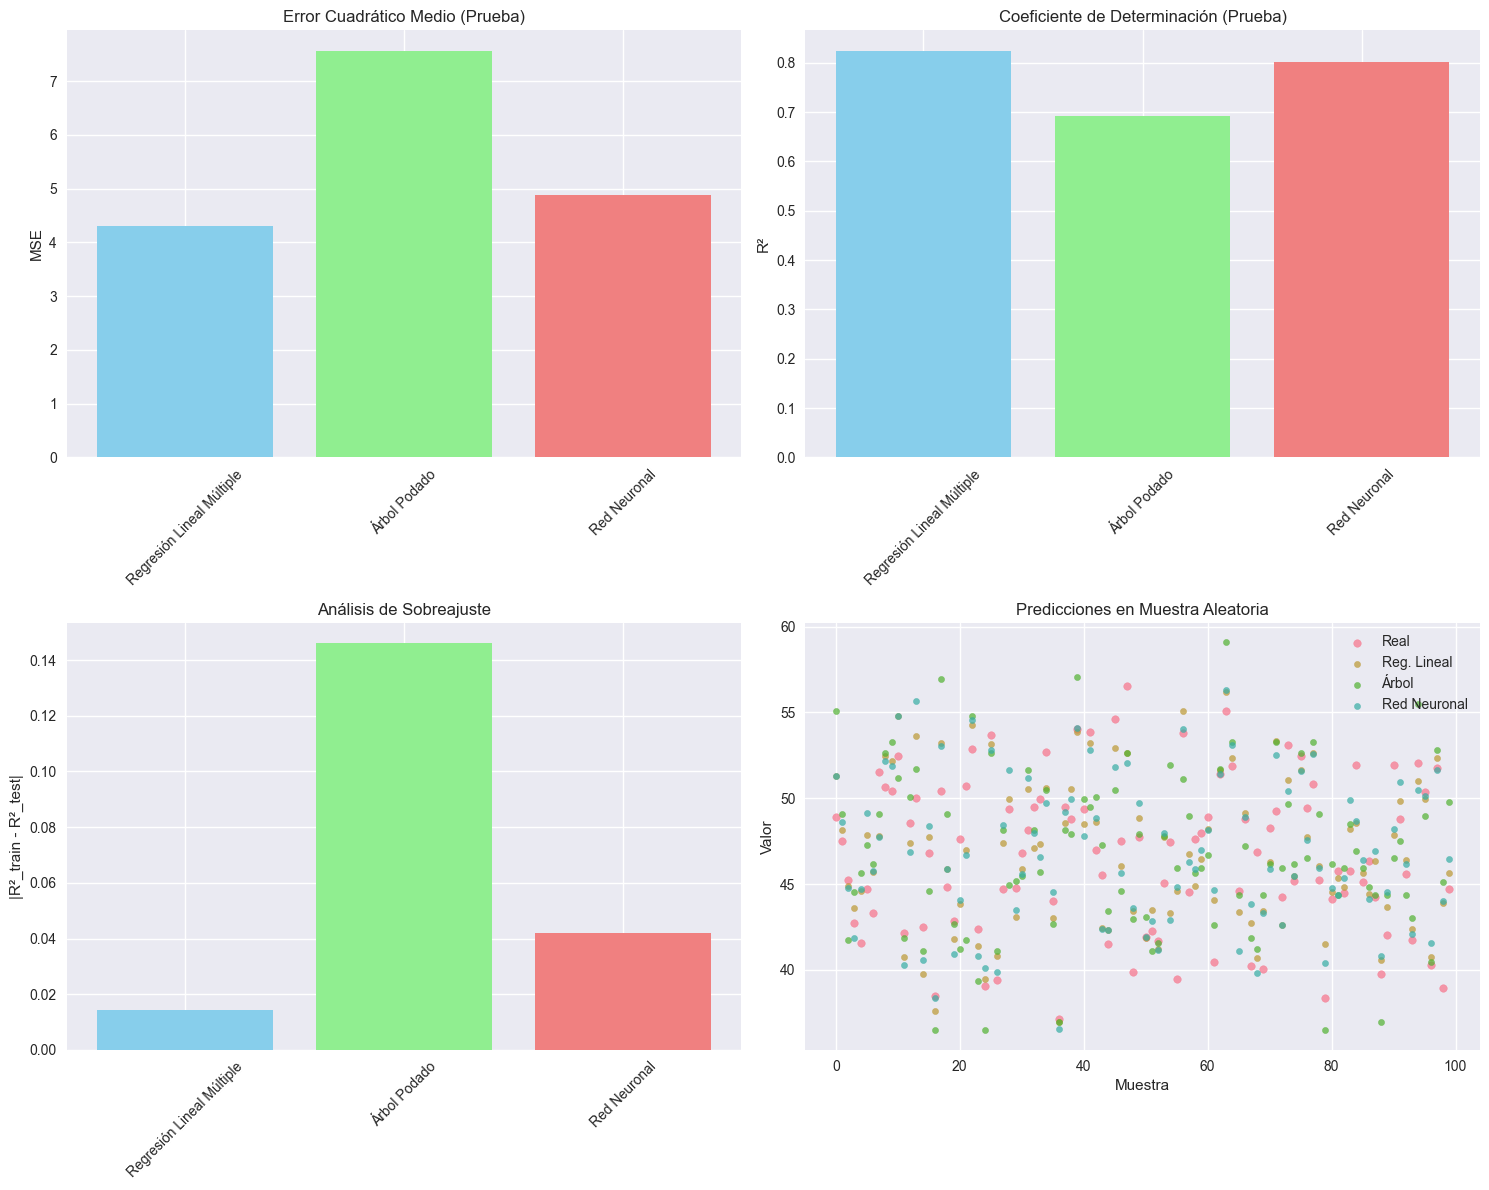

In [181]:
## Celda 11: Visualizaci√≥n Comparativa
# Gr√°ficos de comparaci√≥n
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Gr√°fico 1: MSE Comparaci√≥n
axes[0, 0].bar(models, test_mse, color=['skyblue', 'lightgreen', 'lightcoral'])
axes[0, 0].set_ylabel('MSE')
axes[0, 0].set_title('Error Cuadr√°tico Medio (Prueba)')
axes[0, 0].tick_params(axis='x', rotation=45)

# Gr√°fico 2: R¬≤ Comparaci√≥n
axes[0, 1].bar(models, test_r2, color=['skyblue', 'lightgreen', 'lightcoral'])
axes[0, 1].set_ylabel('R¬≤')
axes[0, 1].set_title('Coeficiente de Determinaci√≥n (Prueba)')
axes[0, 1].tick_params(axis='x', rotation=45)

# Gr√°fico 3: Overfitting an√°lisis
overfitting = [abs(train_r2[i] - test_r2[i]) for i in range(3)]
axes[1, 0].bar(models, overfitting, color=['skyblue', 'lightgreen', 'lightcoral'])
axes[1, 0].set_ylabel('|R¬≤_train - R¬≤_test|')
axes[1, 0].set_title('An√°lisis de Sobreajuste')
axes[1, 0].tick_params(axis='x', rotation=45)


# Gr√°fico 4: Predicciones comparativas
sample_indices = np.random.choice(len(y_test), 100, replace=False)
x_pos = np.arange(len(sample_indices))

axes[1, 1].scatter(x_pos, y_test.iloc[sample_indices], alpha=0.7, label='Real', s=30)
axes[1, 1].scatter(x_pos, y_pred_lr_test[sample_indices], alpha=0.7, label='Reg. Lineal', s=20)
axes[1, 1].scatter(x_pos, y_pred_tree_test[sample_indices], alpha=0.7, label='√Årbol', s=20)
axes[1, 1].scatter(x_pos, y_pred_mlp_test[sample_indices], alpha=0.7, label='Red Neuronal', s=20)
axes[1, 1].set_xlabel('Muestra')
axes[1, 1].set_ylabel('Valor')
axes[1, 1].set_title('Predicciones en Muestra Aleatoria')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

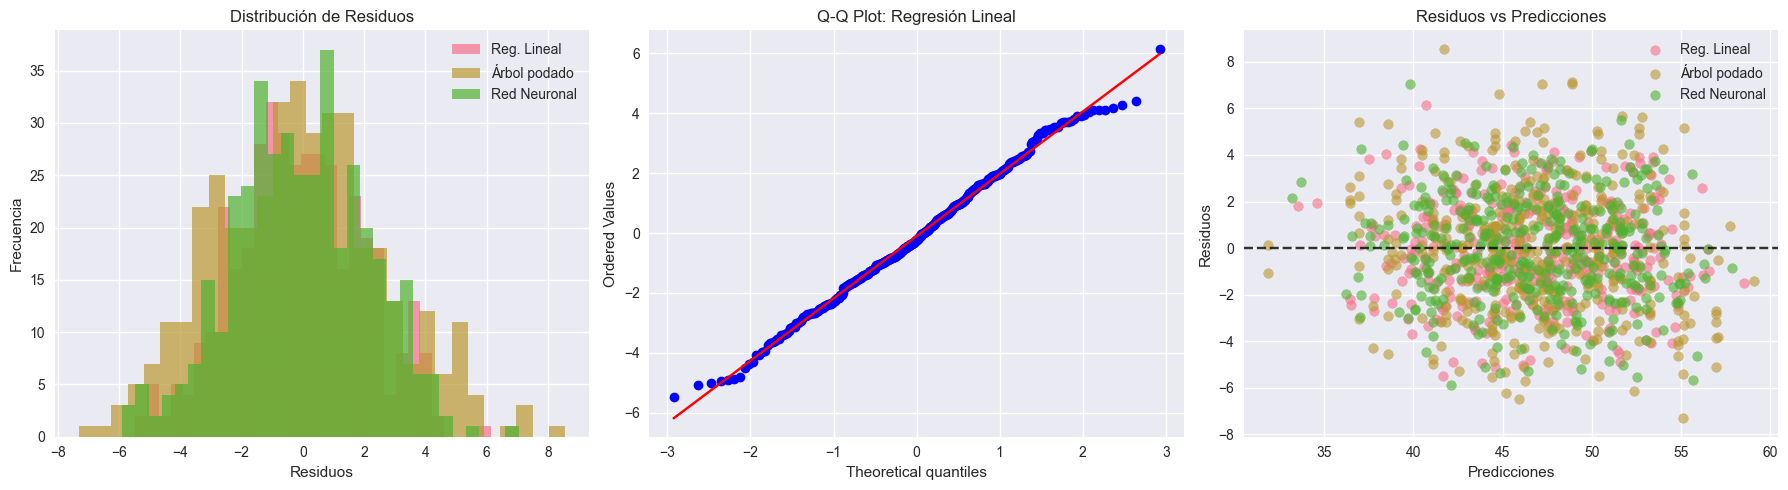

In [182]:
## Celda 12: An√°lisis de Residuos Comparativo
# An√°lisis detallado de residuos
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Residuos de cada modelo
residuals_lr = y_test - y_pred_lr_test
residuals_tree = y_test - y_pred_tree_poda_test
residuals_mlp = y_test - y_pred_mlp_test

# Histogramas de residuos
axes[0].hist(residuals_lr, bins=30, alpha=0.7, label='Reg. Lineal')
axes[0].hist(residuals_tree, bins=30, alpha=0.7, label='√Årbol podado')
axes[0].hist(residuals_mlp, bins=30, alpha=0.7, label='Red Neuronal')
axes[0].set_xlabel('Residuos')
axes[0].set_ylabel('Frecuencia')
axes[0].set_title('Distribuci√≥n de Residuos')
axes[0].legend()

# Q-Q plot para normalidad (solo regresi√≥n lineal)
from scipy import stats
stats.probplot(residuals_lr, dist="norm", plot=axes[1])
axes[1].set_title('Q-Q Plot: Regresi√≥n Lineal')

# Residuos vs predicciones
axes[2].scatter(y_pred_lr_test, residuals_lr, alpha=0.6, label='Reg. Lineal')
axes[2].scatter(y_pred_tree_test, residuals_tree, alpha=0.6, label='√Årbol podado')
axes[2].scatter(y_pred_mlp_test, residuals_mlp, alpha=0.6, label='Red Neuronal')
axes[2].axhline(y=0, color='black', linestyle='--', alpha=0.8)
axes[2].set_xlabel('Predicciones')
axes[2].set_ylabel('Residuos')
axes[2].set_title('Residuos vs Predicciones')
axes[2].legend()

plt.tight_layout()
plt.show()

In [183]:
print("Analisis de Residuos")
print('''
En el gr√°fico de distribuci√≥n de residuos, se observa que los errores se concentran en torno al cero y presentan una forma aproximadamente sim√©trica en los tres casos, lo cual es un buen indicio de ajuste. 

El Q-Q plot correspondiente a la Regresi√≥n Lineal muestra una alineaci√≥n bastante cercana entre los cuantiles te√≥ricos y los observados, lo que indica que los residuos siguen razonablemente una distribuci√≥n normal, con algunas peque√±as desviaciones en las colas. 

Por otro lado, en el gr√°fico de residuos vs predicciones, no se identifican patrones claros en ninguno de los modelos.''')

Analisis de Residuos

En el gr√°fico de distribuci√≥n de residuos, se observa que los errores se concentran en torno al cero y presentan una forma aproximadamente sim√©trica en los tres casos, lo cual es un buen indicio de ajuste. 

El Q-Q plot correspondiente a la Regresi√≥n Lineal muestra una alineaci√≥n bastante cercana entre los cuantiles te√≥ricos y los observados, lo que indica que los residuos siguen razonablemente una distribuci√≥n normal, con algunas peque√±as desviaciones en las colas. 

Por otro lado, en el gr√°fico de residuos vs predicciones, no se identifican patrones claros en ninguno de los modelos.


=== AN√ÅLISIS POR SEGMENTOS ===
  Segmento  Tama√±o  Reg_Lineal_R2  Arbol_R2  Red_Neuronal_R2
0     Bajo     133         0.2997   -0.1877           0.2494
1    Medio     134        -0.9983   -1.7379          -1.3217
2     Alto     133         0.1093   -0.9623          -0.0394


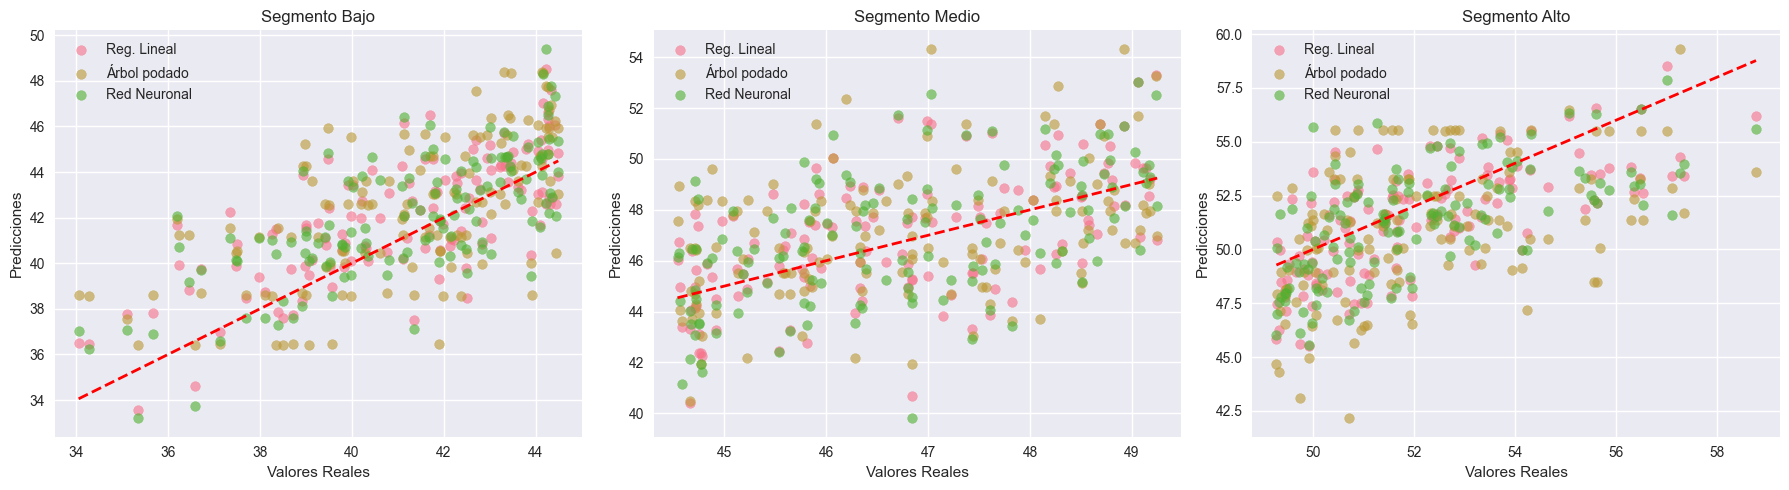

In [185]:
## Celda 13: An√°lisis de Segmentos de Datos
# An√°lisis por rangos de la variable objetivo
print("=== AN√ÅLISIS POR SEGMENTOS ===")

# Dividir datos en terciles
y_test_array = y_test.values
terciles = np.percentile(y_test_array, [33.33, 66.67])
low_mask = y_test_array < terciles[0]
mid_mask = (y_test_array >= terciles[0]) & (y_test_array < terciles[1])
high_mask = y_test_array >= terciles[1]

segments = ['Bajo', 'Medio', 'Alto']
masks = [low_mask, mid_mask, high_mask]


# Calcular m√©tricas por segmento
segment_results = []
for i, mask in enumerate(masks):
    if np.sum(mask) > 0:
        lr_r2 = r2_score(y_test_array[mask], y_pred_lr_test[mask])
        tree_r2 = r2_score(y_test_array[mask], y_pred_tree_poda_test[mask])
        mlp_r2 = r2_score(y_test_array[mask], y_pred_mlp_test[mask])
        
        segment_results.append({
            'Segmento': segments[i],
            'Tama√±o': np.sum(mask),
            'Reg_Lineal_R2': lr_r2,
            'Arbol_R2': tree_r2,
            'Red_Neuronal_R2': mlp_r2
        })


segment_df = pd.DataFrame(segment_results)
print(segment_df.round(4))


# Visualizaci√≥n por segmentos
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, (segment, mask) in enumerate(zip(segments, masks)):
    if np.sum(mask) > 0:
        axes[i].scatter(y_test_array[mask], y_pred_lr_test[mask], alpha=0.6, label='Reg. Lineal')
        axes[i].scatter(y_test_array[mask], y_pred_tree_poda_test[mask], alpha=0.6, label='√Årbol podado')
        axes[i].scatter(y_test_array[mask], y_pred_mlp_test[mask], alpha=0.6, label='Red Neuronal')
        axes[i].plot([y_test_array[mask].min(), y_test_array[mask].max()], 
                    [y_test_array[mask].min(), y_test_array[mask].max()], 'r--', lw=2)
        axes[i].set_xlabel('Valores Reales')
        axes[i].set_ylabel('Predicciones')
        axes[i].set_title(f'Segmento {segment}')
        axes[i].legend()

plt.tight_layout()
plt.show()

In [186]:
print("Analisis de rendimiento en diferentes rangos")

print('''
Al segmentar los datos en terciles seg√∫n el valor objetivo, se observa que:
      
#Segmento Bajo: La regresi√≥n lineal presenta un desempe√±o aceptable con un R^2 de aproximadamente 0.30, superando claramente a los otros modelos. 
Tanto el √°rbol como la red neuronal obtienen valores negativos, reflejando un mal ajuste en esta zona.

Segmento Medio: Ninguno de los modelos logra un buen desempe√±o en este rango, con R^2 fuertemente negativos, lo que indica que la predicci√≥n es peor que simplemente usar la media.

Segmento Alto: La regresi√≥n lineal mantiene un rendimiento superior al resto, con un R^2 positivo pero bajo (~0.11). 
El √°rbol y la red neuronal contin√∫an con valores negativos, mostrando dificultades para modelar los valores m√°s altos.

En conclusi√≥n, la regresi√≥n lineal es el modelo que mejor se adapta a los datos en los segmentos bajo y alto.''')

Analisis de rendimiento en diferentes rangos

Al segmentar los datos en terciles seg√∫n el valor objetivo, se observa que:

#Segmento Bajo: La regresi√≥n lineal presenta un desempe√±o aceptable con un R^2 de aproximadamente 0.30, superando claramente a los otros modelos. 
Tanto el √°rbol como la red neuronal obtienen valores negativos, reflejando un mal ajuste en esta zona.

Segmento Medio: Ninguno de los modelos logra un buen desempe√±o en este rango, con R^2 fuertemente negativos, lo que indica que la predicci√≥n es peor que simplemente usar la media.

Segmento Alto: La regresi√≥n lineal mantiene un rendimiento superior al resto, con un R^2 positivo pero bajo (~0.11). 
El √°rbol y la red neuronal contin√∫an con valores negativos, mostrando dificultades para modelar los valores m√°s altos.

En conclusi√≥n, la regresi√≥n lineal es el modelo que mejor se adapta a los datos en los segmentos bajo y alto.


In [187]:
## Celda 14: Validaci√≥n Cruzada Completa
print("=== VALIDACI√ìN CRUZADA COMPLETA ===")

from sklearn.model_selection import cross_validate

# Definir m√©tricas para evaluaci√≥n
scoring = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']

# Validaci√≥n cruzada para cada modelo
models_cv = {
    'Regresi√≥n Lineal': LinearRegression(),
    '√Årbol de Regresi√≥n': tree_model_poda ,  # Usar el √°rbol podado
    'Red Neuronal': MLPRegressor(hidden_layer_sizes=best_architecture, max_iter=500, random_state=42)
}

cv_results = {}
for name, model in models_cv.items():
    if name == 'Red Neuronal':
        # Para red neuronal usar datos escalados
        scores = cross_validate(model, X_train_scaled, y_train, cv=5, scoring=scoring)
    else:
        scores = cross_validate(model, X_train, y_train, cv=5, scoring=scoring)
    
    cv_results[name] = {
        'R2': scores['test_r2'].mean(),
        'R2_std': scores['test_r2'].std(),
        'MSE': -scores['test_neg_mean_squared_error'].mean(),
        'MSE_std': scores['test_neg_mean_squared_error'].std(),
        'MAE': -scores['test_neg_mean_absolute_error'].mean(),
        'MAE_std': scores['test_neg_mean_absolute_error'].std()
    }


# Mostrar resultados
cv_df = pd.DataFrame(cv_results).T
print("Resultados de Validaci√≥n Cruzada (5-fold):")
print(cv_df.round(4))

=== VALIDACI√ìN CRUZADA COMPLETA ===
Resultados de Validaci√≥n Cruzada (5-fold):
                        R2  R2_std     MSE  MSE_std     MAE  MAE_std
Regresi√≥n Lineal    0.8363  0.0225  3.9591   0.4025  1.5828   0.0876
√Årbol de Regresi√≥n  0.7007  0.0335  7.2425   0.5336  2.1636   0.0666
Red Neuronal        0.8168  0.0248  4.4290   0.4184  1.6915   0.0980


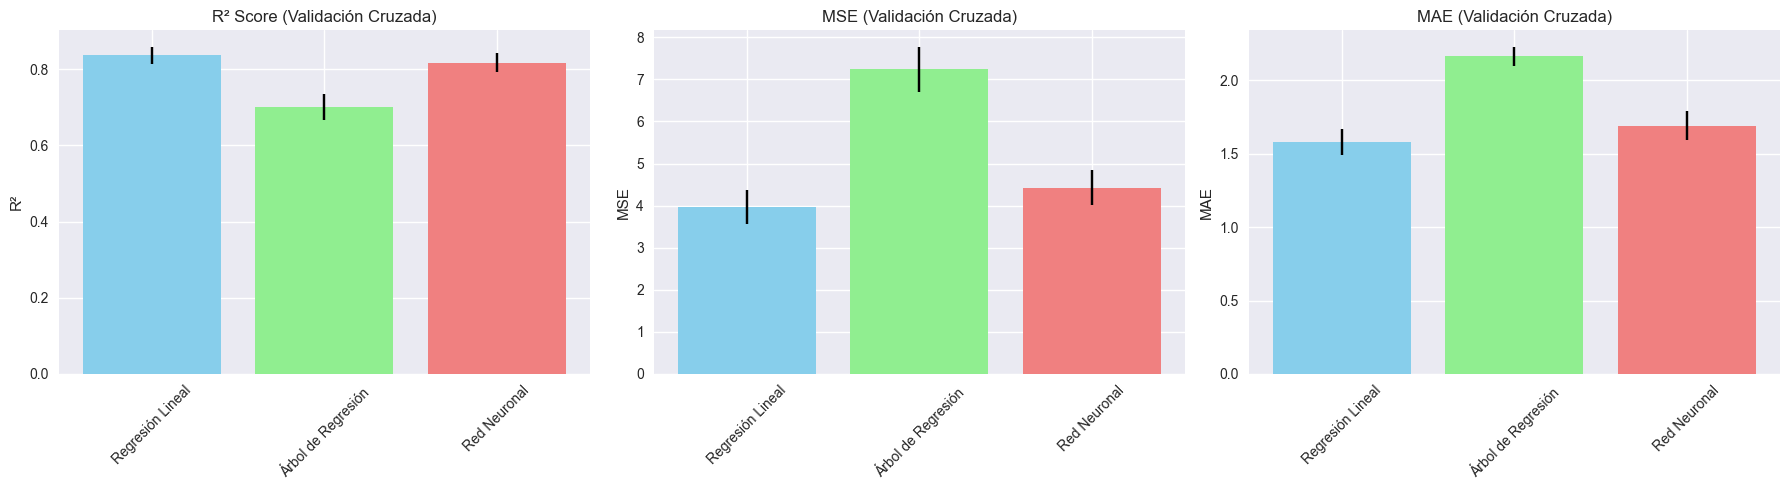

In [188]:
# Gr√°fico de barras con intervalos de confianza
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

models_names = list(cv_results.keys())
r2_means = [cv_results[name]['R2'] for name in models_names]
r2_stds = [cv_results[name]['R2_std'] for name in models_names]

mse_means = [cv_results[name]['MSE'] for name in models_names]
mse_stds = [cv_results[name]['MSE_std'] for name in models_names]

# R¬≤ con intervalos de confianza
axes[0].bar(models_names, r2_means, yerr=r2_stds, capsize=5, color=['skyblue', 'lightgreen', 'lightcoral'])
axes[0].set_ylabel('R¬≤')
axes[0].set_title('R¬≤ Score (Validaci√≥n Cruzada)')
axes[0].tick_params(axis='x', rotation=45)

# MSE con intervalos de confianza
axes[1].bar(models_names, mse_means, yerr=mse_stds, capsize=5, color=['skyblue', 'lightgreen', 'lightcoral'])
axes[1].set_ylabel('MSE')
axes[1].set_title('MSE (Validaci√≥n Cruzada)')
axes[1].tick_params(axis='x', rotation=45)

# Calcular MAE y su desviaci√≥n est√°ndar
mae_means = [cv_results[name]['MAE'] for name in models_names]
mae_stds = [cv_results[name]['MAE_std'] for name in models_names]

# MAE con intervalos de confianza
axes[2].bar(models_names, mae_means, yerr=mae_stds, capsize=5, color=['skyblue', 'lightgreen', 'lightcoral'])
axes[2].set_ylabel('MAE')
axes[2].set_title('MAE (Validaci√≥n Cruzada)')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [189]:
print("Comparaci√≥n estad√≠stica")
print('''
Los gr√°ficos incluyen intervalos de confianza construidos a partir de la desviaci√≥n est√°ndar de los resultados en cada partici√≥n. 
La comparaci√≥n de los intervalos cumple una funci√≥n equivalente a la de un test de significancia, permitiendo inferir si las diferencias observadas entre modelos podr√≠an considerarse relevantes desde el punto de vista estad√≠stico. 
En este caso, los intervalos del √Årbol Podado no se superponen con los de los otros modelos en MSE y MAE, lo que sugiere una diferencia significativa en el rendimiento. 
En cambio, la superposici√≥n parcial entre la Regresi√≥n Lineal y la Red Neuronal indica que sus desempe√±os son comparables dentro del margen de error observado.''')

Comparaci√≥n estad√≠stica

Los gr√°ficos incluyen intervalos de confianza construidos a partir de la desviaci√≥n est√°ndar de los resultados en cada partici√≥n. 
La comparaci√≥n de los intervalos cumple una funci√≥n equivalente a la de un test de significancia, permitiendo inferir si las diferencias observadas entre modelos podr√≠an considerarse relevantes desde el punto de vista estad√≠stico. 
En este caso, los intervalos del √Årbol Podado no se superponen con los de los otros modelos en MSE y MAE, lo que sugiere una diferencia significativa en el rendimiento. 
En cambio, la superposici√≥n parcial entre la Regresi√≥n Lineal y la Red Neuronal indica que sus desempe√±os son comparables dentro del margen de error observado.


In [190]:
# === TEST DE FRIEDMAN PARA COMPARACI√ìN DE MODELOS ===
# Lo elijo pues:
# Estamos comparando TRES modelos (m√°s de dos)
# Cada modelo fue evaluado en los mismos 5 folds (mediciones repetidas)


# Obtener R¬≤ de cada modelo en cada fold (validaci√≥n cruzada)
lr_scores = cross_val_score(LinearRegression(), X_train, y_train, cv=5, scoring='r2')
tree_scores = cross_val_score(DecisionTreeRegressor(max_depth=best_depth, random_state=42), X_train, y_train, cv=5, scoring='r2')
mlp_scores = cross_val_score(MLPRegressor(hidden_layer_sizes=best_architecture, max_iter=500, random_state=42), X_train_scaled, y_train, cv=5, scoring='r2')

# Aplicar test de Friedman
stat, p = friedmanchisquare(lr_scores, tree_scores, mlp_scores)

# Mostrar resultados
print("=== TEST DE FRIEDMAN ===")
print(f"Estad√≠stico de Friedman: {stat:.4f}")
print(f"Valor p: {p:.4f}")

if p < 0.05:
    print("‚Üí Hay diferencias estad√≠sticamente significativas entre al menos dos modelos.")
else:
    print("‚Üí No se detectaron diferencias significativas entre los modelos.")

=== TEST DE FRIEDMAN ===
Estad√≠stico de Friedman: 10.0000
Valor p: 0.0067
‚Üí Hay diferencias estad√≠sticamente significativas entre al menos dos modelos.


In [191]:
print("Se realiz√≥ un test de significancia estad√≠stica")

print('''
Para evaluar si las diferencias en el rendimiento de los modelos observadas durante la validaci√≥n cruzada eran estad√≠sticamente significativas, se aplic√≥ el test de Friedman.
Este test no param√©trico es apropiado cuando se comparan tres o m√°s modelos evaluados sobre los mismos subconjuntos de datos (en este caso, los 5 folds de la validaci√≥n cruzada), sin asumir normalidad en las diferencias de rendimiento.
El test se aplic√≥ sobre las puntuaciones de R^2 obtenidas por los modelos de regresi√≥n lineal, √°rbol de regresi√≥n y red neuronal. 
Dado que el valor p es menor a 0.05, se concluye que existen diferencias estad√≠sticamente significativas entre al menos dos de los modelos evaluados. 
Esto respalda la interpretaci√≥n de que no todos los modelos tienen un desempe√±o equivalente, lo que justifica la comparaci√≥n detallada y la selecci√≥n del mejor modelo seg√∫n las m√©tricas de rendimiento.''')

Se realiz√≥ un test de significancia estad√≠stica

Para evaluar si las diferencias en el rendimiento de los modelos observadas durante la validaci√≥n cruzada eran estad√≠sticamente significativas, se aplic√≥ el test de Friedman.
Este test no param√©trico es apropiado cuando se comparan tres o m√°s modelos evaluados sobre los mismos subconjuntos de datos (en este caso, los 5 folds de la validaci√≥n cruzada), sin asumir normalidad en las diferencias de rendimiento.
El test se aplic√≥ sobre las puntuaciones de R^2 obtenidas por los modelos de regresi√≥n lineal, √°rbol de regresi√≥n y red neuronal. 
Dado que el valor p es menor a 0.05, se concluye que existen diferencias estad√≠sticamente significativas entre al menos dos de los modelos evaluados. 
Esto respalda la interpretaci√≥n de que no todos los modelos tienen un desempe√±o equivalente, lo que justifica la comparaci√≥n detallada y la selecci√≥n del mejor modelo seg√∫n las m√©tricas de rendimiento.


In [192]:
## Celda 15: Conclusiones y Recomendaciones
print("=== CONCLUSIONES Y RECOMENDACIONES ===")

# Resumen final
print("\nüìä RESUMEN EJECUTIVO:")
print("="*50)

# Mejor modelo general
best_cv_model = max(cv_results.keys(), key=lambda x: cv_results[x]['R2'])
print(f"üèÜ Mejor modelo (Validaci√≥n Cruzada): {best_cv_model}")
print(f"   R¬≤ = {cv_results[best_cv_model]['R2']:.4f} ¬± {cv_results[best_cv_model]['R2_std']:.4f}")

# An√°lisis de complejidad vs rendimiento
print(f"\nüìà AN√ÅLISIS DE RENDIMIENTO:")
print(f"‚Ä¢ Regresi√≥n Lineal: Simple, interpretable, R¬≤ = {cv_results['Regresi√≥n Lineal']['R2']:.4f}")
print(f"‚Ä¢ √Årbol de Regresi√≥n: Captura no-linealidades, R¬≤ = {cv_results['√Årbol de Regresi√≥n']['R2']:.4f}")
print(f"‚Ä¢ Red Neuronal: M√°s compleja, R¬≤ = {cv_results['Red Neuronal']['R2']:.4f}")
print("=" * 80)
print('''Se evaluaron tres modelos de regresi√≥n para predecir la variable objetivo: regresi√≥n lineal m√∫ltiple, √°rbol de regresi√≥n podado y red neuronal (MLP). La comparaci√≥n se realiz√≥ utilizando m√©tricas cl√°sicas como el error cuadr√°tico medio (MSE), el coeficiente de determinaci√≥n (R¬≤) y el error absoluto medio (MAE), tanto en los conjuntos de entrenamiento como de prueba, complementado con una validaci√≥n cruzada de 5 folds para evaluar la estabilidad de los modelos.
En el conjunto de prueba, la regresi√≥n lineal m√∫ltiple fue el modelo con mejor desempe√±o, presentando un R¬≤ de 0.8244, lo que indica que explica aproximadamente el 82.44% de la variabilidad de los datos no vistos. Adem√°s, mostr√≥ un MSE de 4.3027 y un MAE de 1.6855, siendo estas las mejores m√©tricas entre los tres modelos evaluados, reflejando predicciones m√°s precisas y errores absolutos menores. La red neuronal qued√≥ en segundo lugar con un R¬≤ de 0.8012, un MSE de 4.8723 y un MAE de 1.7956, lo que indica un rendimiento cercano pero ligeramente inferior al de la regresi√≥n lineal. Por √∫ltimo, el √°rbol de regresi√≥n podado mostr√≥ el desempe√±o m√°s bajo, con un R¬≤ de 0.6914, un MSE significativamente mayor de 7.5627 y un MAE de 2.3615, reflejando menor capacidad para generalizar y mayor error en sus predicciones.
La validaci√≥n cruzada de cinco folds corrobor√≥ estos resultados, confirmando la estabilidad y consistencia de los modelos.      
La regresi√≥n lineal multiple mantuvo el mejor promedio en R¬≤ (0.8363), el menor MSE (3.9591) y el menor MAE (1.5828), adem√°s de la menor desviaci√≥n est√°ndar en estas m√©tricas, lo que indica que sus resultados son consistentes en diferentes subconjuntos del conjunto de entrenamiento.
La red neuronal present√≥ resultados similares, aunque con mayor variabilidad, mientras que el √°rbol de regresi√≥n fue nuevamente el menos efectivo, mostrando menor promedio de R¬≤ y mayor error y variabilidad.
Adicionalmente, se realiz√≥ un an√°lisis segmentado dividiendo la variable objetivo en tres rangos seg√∫n sus terciles: bajo, medio y alto. Los modelos mostraron un desempe√±o moderado en el segmento bajo, donde la regresi√≥n lineal logr√≥ un R¬≤ positivo cercano a 0.30 y la red neuronal tambi√©n mostr√≥ un desempe√±o aceptable, mientras que el √°rbol no logr√≥ resultados satisfactorios.
Sin embargo, en los segmentos medio y alto, los tres modelos presentaron R¬≤ negativos, lo que indica que sus predicciones son peores que simplemente usar la media para esos rangos. Esto se√±ala que los modelos actuales tienen limitaciones para capturar el comportamiento en valores medios y altos de la variable objetivo, lo que podr√≠a deberse a falta de datos representativos o a la necesidad de incorporar nuevas caracter√≠sticas o enfoques m√°s complejos.

En resumen, la regresi√≥n lineal m√∫ltiple es el modelo m√°s adecuado para este problema, ya que combina un alto poder explicativo, precisi√≥n en las predicciones y estabilidad. 
La red neuronal representa una alternativa v√°lida con un rendimiento cercano, aunque con mayor variabilidad, mientras que el √°rbol podado presenta un desempe√±o inferior y es menos recomendable.
 ''')
print("=" * 80)
print('''
Limitaciones:     
A pesar de que la regresi√≥n lineal m√∫ltiple mostr√≥ el mejor desempe√±o general, existen varias limitaciones importantes en este estudio que conviene considerar. ' \
En primer lugar, el an√°lisis segmentado revel√≥ que ninguno de los modelos logra predecir bien los valores medios y altos de la variable objetivo, lo que indica que el modelo no captura adecuadamente la complejidad o no dispone de suficientes datos representativos en esos rangos.
Adem√°s, la selecci√≥n de caracter√≠sticas y la calidad de los datos pueden afectar la capacidad predictiva. Si las variables usadas no representan suficientemente los factores que influyen en el objetivo, los modelos tendr√°n un rendimiento limitado, especialmente en casos no lineales o con interacciones complejas.
Por otro lado, el √°rbol de regresi√≥n podado mostr√≥ un desempe√±o inferior, lo que puede deberse a una poda demasiado agresiva o a que su capacidad para capturar patrones complejos fue limitada. ''')
print("="*50)
print('''
Para mejorar los resultados y la robustez de los modelos, se recomienda en primer lugar ampliar y diversificar el conjunto de datos, incluyendo m√°s ejemplos especialmente en los segmentos medio y alto, donde los modelos actuales presentan un desempe√±o deficiente. 
Esto ayudar√≠a a que los modelos puedan aprender mejor los patrones complejos y generalizar mejor.''')

=== CONCLUSIONES Y RECOMENDACIONES ===

üìä RESUMEN EJECUTIVO:
üèÜ Mejor modelo (Validaci√≥n Cruzada): Regresi√≥n Lineal
   R¬≤ = 0.8363 ¬± 0.0225

üìà AN√ÅLISIS DE RENDIMIENTO:
‚Ä¢ Regresi√≥n Lineal: Simple, interpretable, R¬≤ = 0.8363
‚Ä¢ √Årbol de Regresi√≥n: Captura no-linealidades, R¬≤ = 0.7007
‚Ä¢ Red Neuronal: M√°s compleja, R¬≤ = 0.8168
Se evaluaron tres modelos de regresi√≥n para predecir la variable objetivo: regresi√≥n lineal m√∫ltiple, √°rbol de regresi√≥n podado y red neuronal (MLP). La comparaci√≥n se realiz√≥ utilizando m√©tricas cl√°sicas como el error cuadr√°tico medio (MSE), el coeficiente de determinaci√≥n (R¬≤) y el error absoluto medio (MAE), tanto en los conjuntos de entrenamiento como de prueba, complementado con una validaci√≥n cruzada de 5 folds para evaluar la estabilidad de los modelos.
En el conjunto de prueba, la regresi√≥n lineal m√∫ltiple fue el modelo con mejor desempe√±o, presentando un R¬≤ de 0.8244, lo que indica que explica aproximadamente el 82.4